In [1]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

# Get ZTF fit

In [2]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [3]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [4]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

fink_colors = ['#15284F', '#F5622E']

V_minus_g = -0.2833
V_minus_r = 0.1777

In [5]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [6]:
data.columns


Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit', 'SHG1G2_R',
       'SHG1G2_min_cos_lambda', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_G2_g',
       'SHG1G2_G1_r', 'SHG1G2_ddelta0', 'SHG1G2_G1_g', 'std_astrometry',
       'SHG1G2_delta0', 'n_days_r', 'SHG1G2_G2_r', 'n_days_g',
       'SHG1G2_chi2red', 'min_phase', 'SHG1G2_dH_g', 'SHG1G2_dH_r',
       'SHG1G2_rms_r', 'last_jd', 'SHG

In [7]:
data['SHG1G2_dSpin'] = np.sqrt( (data['SHG1G2_dalpha0']*np.cos(np.radians(data['SHG1G2_delta0'])))**2 + data['SHG1G2_ddelta0']**2 )


# # Remove solutions above 90 deg of latitude
cond = data.SHG1G2_delta0 > 90
data.loc[cond,'SHG1G2_delta0'] = 90
print(f'above 90: {len(data[cond])} ')

cond = data.SHG1G2_delta0 < -90
data.loc[cond,'SHG1G2_delta0'] = -90
print(f'below 90: {len(data[cond])} ')


above 90: 0 
below 90: 0 


In [8]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'proper_elements.proper_semi_major_axis.value',
        'proper_elements.proper_eccentricity.value',
        'proper_elements.proper_inclination.value',
        'proper_elements.proper_sine_inclination.value',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value', 'spins.1.RA0.error.max', 'spins.1.DEC0.error.max',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value', 'spins.2.RA0.error.max', 'spins.2.DEC0.error.max',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value', 'spins.3.RA0.error.max', 'spins.3.DEC0.error.max',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value', 'spins.4.RA0.error.max', 'spins.4.DEC0.error.max',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]      
bft = pd.read_parquet(bft_file, columns=cols)

In [9]:
data = data.merge( bft, left_on='name', right_on='sso_name', how='left' )

In [10]:
# data

In [11]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_SHG1G2_g = (data.SHG1G2_G1_g>thres)  & (data.SHG1G2_G2_g>thres) & ((1-data.SHG1G2_G1_g-data.SHG1G2_G2_g)>thres)
mask_SHG1G2_r = (data.SHG1G2_G1_r>thres)  & (data.SHG1G2_G2_r>thres) & ((1-data.SHG1G2_G1_r-data.SHG1G2_G2_r)>thres)
mask_SHG1G2_ZTF = mask_SHG1G2_g & mask_SHG1G2_r
mask_SHG1G2_fit = (data.SHG1G2_fit==0)  & (data.SHG1G2_status>=2)
mask_SHG1G2 = mask_SHG1G2_fit & mask_SHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.SHG1G2_alpha0>thres) & ( np.abs(360-data.SHG1G2_alpha0)>thres )  & \
           ( np.abs(data.SHG1G2_alpha0-180)>thres) & ( np.abs(data.SHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.min_phase<2.5

# Global mask
mask = mask_HG1G2 & mask_SHG1G2

# Global mask
maskFINK = mask_SHG1G2 & maskSpin #& maskPhase


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_SHG1G2_g]):6d}  ({100.*len(data[mask_SHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_SHG1G2_r]):6d}  ({100.*len(data[mask_SHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_SHG1G2]):6d}  ({100.*len(data[mask_SHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for min_phase in [2,3,4,5]:
    maskPhase = data.min_phase<min_phase
    print(f'  Mask phase {min_phase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_SHG1G2_g]), len(data[mask_SHG1G2_r]), len(data[mask_SHG1G2])

 All data       : 112404  (100.00%)

  Mask HG g      : 112120  ( 99.75%)
  Mask HG r      : 112121  ( 99.75%)
  Mask HG g+r    : 109955  ( 97.82%)

  Mask HG1G2 g   :  57323  ( 51.00%)
  Mask HG1G2 r   :  62116  ( 55.26%)
  Mask HG1G2 g+r :  42027  ( 37.39%)

  Mask SHG1G2 g  :  71733  ( 63.82%)
  Mask SHG1G2 r  :  76365  ( 67.94%)
  Mask SHG1G2 g+r:  57511  ( 51.16%)

  Mask Spin      : 108758  ( 96.76%)

  Mask (both)    :  36180  ( 32.19%)
  Mask phase 2  :  55190  ( 49.10%)
  Mask phase 3  :  76507  ( 68.06%)
  Mask phase 4  :  90348  ( 80.38%)
  Mask phase 5  :  98575  ( 87.70%)


# Abs mag

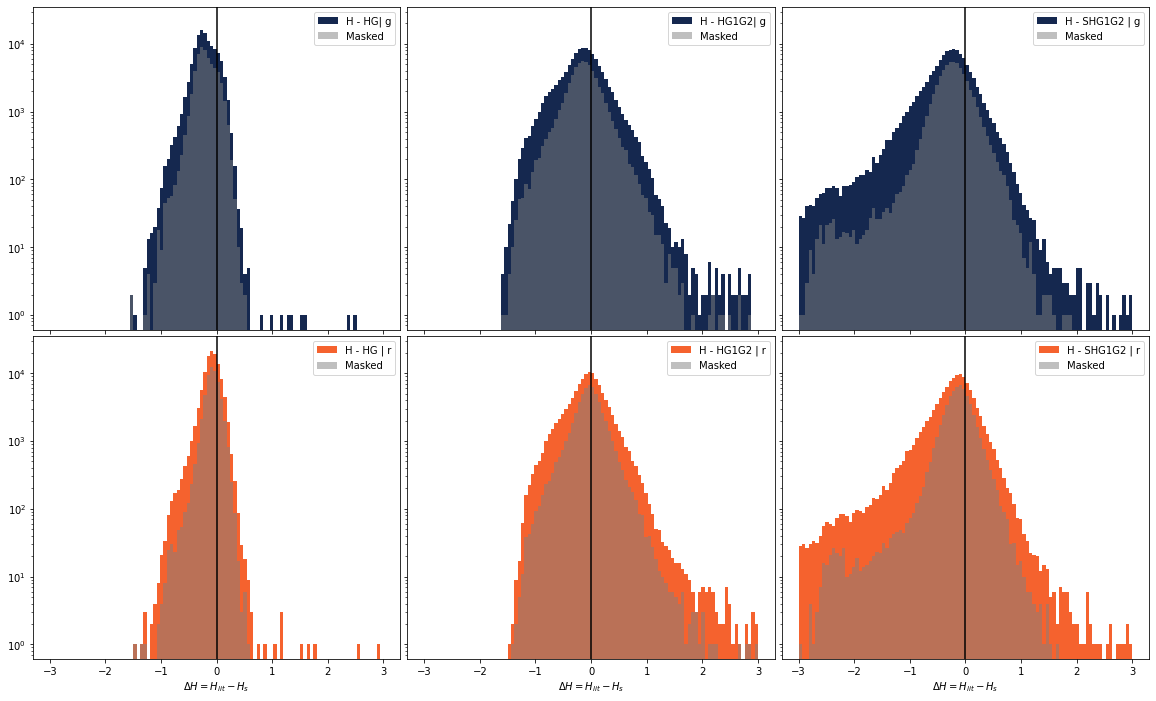

In [12]:
# Different colors
fig, ax = plt.subplots(2, 3, figsize=(20,12), sharex=True, sharey=True, gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-3,3]
b = 100


# HG
x = (data['absolute_magnitude.value'] - data.HG_H_g) - V_minus_g
ax[0,0].hist( x, range=r, bins=b, label='H - HG| g', color=fink_colors[0] )
ax[0,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG_H_r) - V_minus_r
ax[1,0].hist( x, range=r, bins=b, label='H - HG | r', color=fink_colors[1] )
ax[1,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )



# HG1G2
x = (data['absolute_magnitude.value'] - data.HG1G2_H_g) - V_minus_g
ax[0,1].hist( x, range=r, bins=b, label='H - HG1G2| g' , color=fink_colors[0] )
ax[0,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG1G2_H_r) - V_minus_r
ax[1,1].hist( x, range=r, bins=b, label='H - HG1G2 | r', color=fink_colors[1] )
ax[1,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


# SHG1G2
x = (data['absolute_magnitude.value'] - data.SHG1G2_H_g) - V_minus_g
ax[0,2].hist( x, range=r, bins=b, label='H - SHG1G2 | g', color=fink_colors[0] )
ax[0,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.SHG1G2_H_r) - V_minus_r
ax[1,2].hist( x, range=r, bins=b, label='H - SHG1G2 | r', color=fink_colors[1] )
ax[1,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


for a in ax.ravel():
    a.set_xlabel('$\Delta H = H_{lit} - H_s$')
    a.legend(loc='upper right')
    a.set_yscale('log')
    a.axvline(0, color='black')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'H.png'), facecolor='white')

# Spin distribution

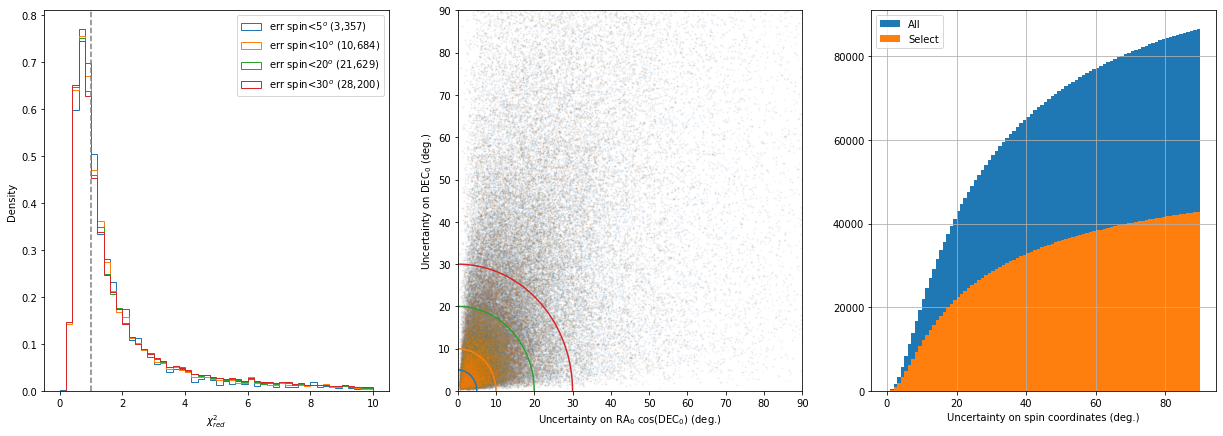

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.SHG1G2_dSpin<=err)
    ax[0].hist(data.loc[cond,'SHG1G2_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.SHG1G2_dalpha0*np.cos(np.radians(data['SHG1G2_delta0'])), data.SHG1G2_ddelta0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'SHG1G2_dalpha0']*np.cos(np.radians(data.loc[maskFINK,'SHG1G2_delta0'])), data.loc[maskFINK,'SHG1G2_ddelta0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.SHG1G2_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'SHG1G2_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


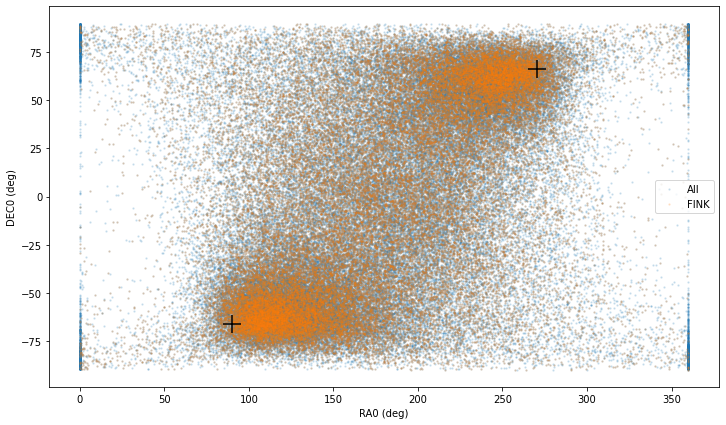

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

# All
cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='All')

# FINK sample
cond = maskFINK
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='FINK')


# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )

coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
ax.legend()

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_bulk.png'), facecolor='white')


- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

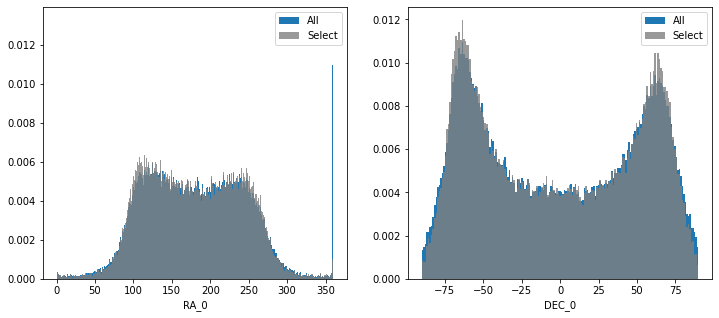

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.SHG1G2_alpha0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'SHG1G2_alpha0'], range=[0,360], bins=361, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.SHG1G2_delta0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'SHG1G2_delta0'], range=[-90,90], bins=181, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [16]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

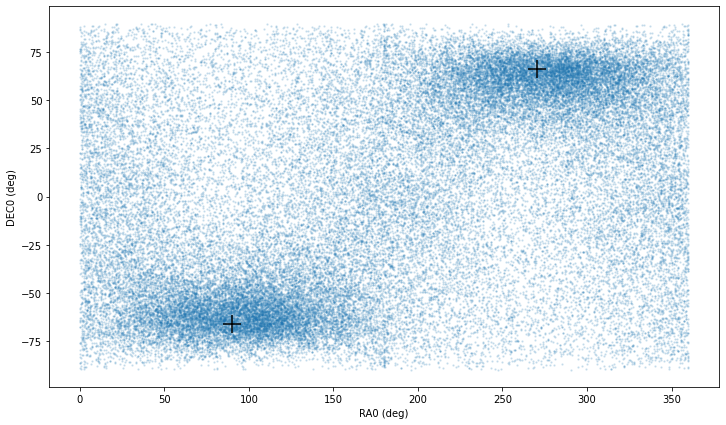

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

# Sample FINK
ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_selected.png'), facecolor='white')


# Compare with literature

In [18]:
data['spins.1.technique'].value_counts()

LC        18066
LCI        2689
LC+TPM      568
TE           69
ADAM         43
LC-TPM       40
Radar        18
LC+Occ       17
SPACE         5
A-M           5
LC+IM         4
SAGE          4
TE-Occ        1
Bin-IM        1
Name: spins.1.technique, dtype: int64

In [19]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'SHG1G2_alpha0','SHG1G2_delta0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'SHG1G2_alpha0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'SHG1G2_delta0'] )
    data.loc[cond,f'spins.{ks}.RA.A'] = data.loc[cond,f'spins.{ks}.RA0.value']
    data.loc[cond,f'spins.{ks}.DEC.A'] = data.loc[cond,f'spins.{ks}.DEC0.value']

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'SHG1G2_alpha0','SHG1G2_delta0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'SHG1G2_alpha0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'SHG1G2_delta0'] )
    data.loc[cond,f'spins.{ks}.RA.B'] = ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )
    data.loc[cond,f'spins.{ks}.DEC.B'] = -data.loc[cond,f'spins.{ks}.DEC0.value']
    
    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.RA'] = data.loc[cond, [f'spins.{ks}.RA.A',
                                                      f'spins.{ks}.RA.B', 
                                                      f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.DEC'] = data.loc[cond, [f'spins.{ks}.RA.A',
                                                       f'spins.{ks}.RA.B', 
                                                       f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )

data.loc[cond,'spins.err_RA'] = data.loc[cond, [f'spins.1.RA0.error.max',
                                                f'spins.2.RA0.error.max',
                                                f'spins.3.RA0.error.max',
                                                f'spins.4.RA0.error.max', 
                                                f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.err_DEC'] = data.loc[cond, [f'spins.1.DEC0.error.max',
                                                 f'spins.2.DEC0.error.max',
                                                 f'spins.3.DEC0.error.max',
                                                 f'spins.4.DEC0.error.max', 
                                                 f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )

data.loc[cond,'spins.RA'] = data.loc[cond, [f'spins.1.RA',
                                            f'spins.2.RA',
                                            f'spins.3.RA',
                                            f'spins.4.RA', 
                                            f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.DEC'] = data.loc[cond, [f'spins.1.DEC',
                                             f'spins.2.DEC',
                                             f'spins.3.DEC',
                                             f'spins.4.DEC', 
                                             f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )


In [20]:
for c in ['spins.RA','spins.DEC','spins.err_RA', 'spins.err_DEC']:
    missing = data[c].isna()
    data.loc[missing,c] = 15.

In [21]:
for c in ['spins.RA','spins.DEC','spins.err_RA', 'spins.err_DEC']:
    missing = data[c].isna()
    print(c, len(data[missing]))
    data[c] = data[c].astype(float)
len(data)

spins.RA 0
spins.DEC 0
spins.err_RA 0
spins.err_DEC 0


112404

In [22]:
data.loc[cond,'spins.dSpin'] = np.sqrt( (data.loc[cond,'spins.err_RA']*np.cos(np.radians(data.loc[cond,'spins.DEC'])))**2 + data.loc[cond,'spins.err_DEC']**2 )


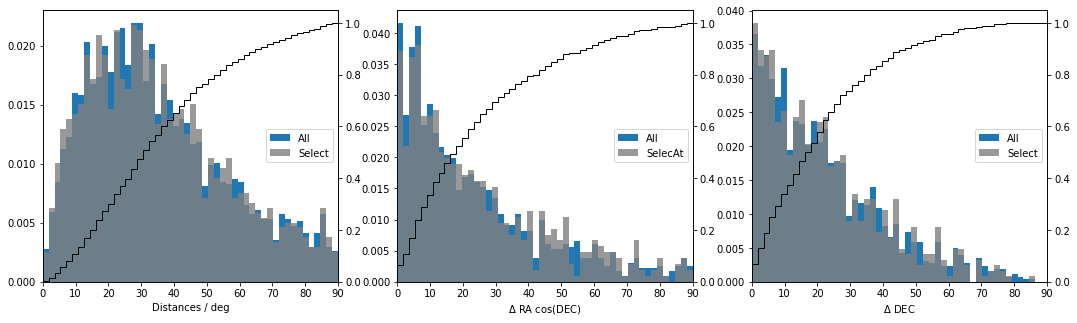

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend(loc='center right')
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='SelecAt', color='grey', alpha=0.8 )
ax[1].legend(loc='center right')
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend(loc='center right')
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances.png'), facecolor='white')


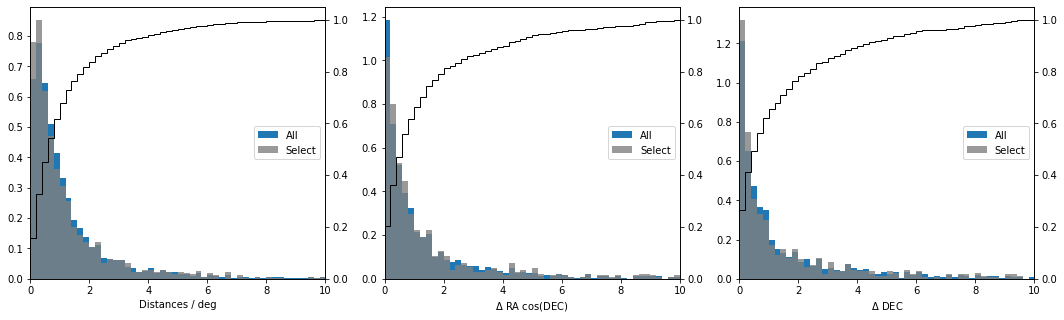

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


r = [0,10]
b = 50

x = data['spins.distance'] / np.sqrt( data['SHG1G2_dSpin']**2 + data['spins.dSpin']**2 )
ax[0].hist( x, range=r, bins=b, density=True, label='All' )
ax[0].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend(loc='center right')
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

x = data['spins.delta_RA'] / data['SHG1G2_dalpha0']
ax[1].hist( x, range=r, bins=b, density=True, label='All' )
ax[1].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend(loc='center right')
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

x = data['spins.delta_DEC'] / data['SHG1G2_ddelta0']
ax[2].hist( x, range=r, bins=b, density=True, label='All' )
ax[2].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend(loc='center right')
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_normed.png'), facecolor='white')

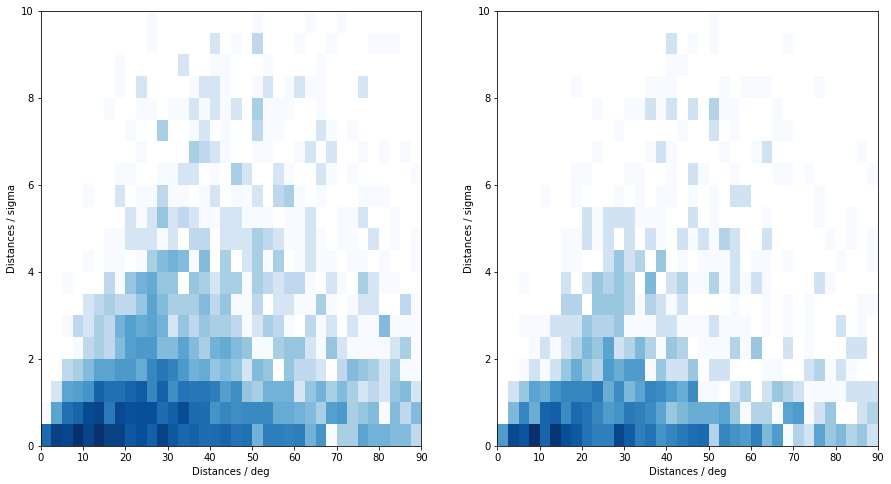

In [25]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,10] ]
b = [36,20]

x = data['spins.distance'] 
y = data['spins.distance'] / data['SHG1G2_dSpin']
ax[0].hist2d( x, y, label='All', range=r, bins=b, cmap='Blues', norm='log', density=True )
ax[1].hist2d( x[maskFINK], y[maskFINK], label='Select', range=r, bins=b, cmap='Blues', norm='log', density=True)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_vs_sigma.png'), facecolor='white')

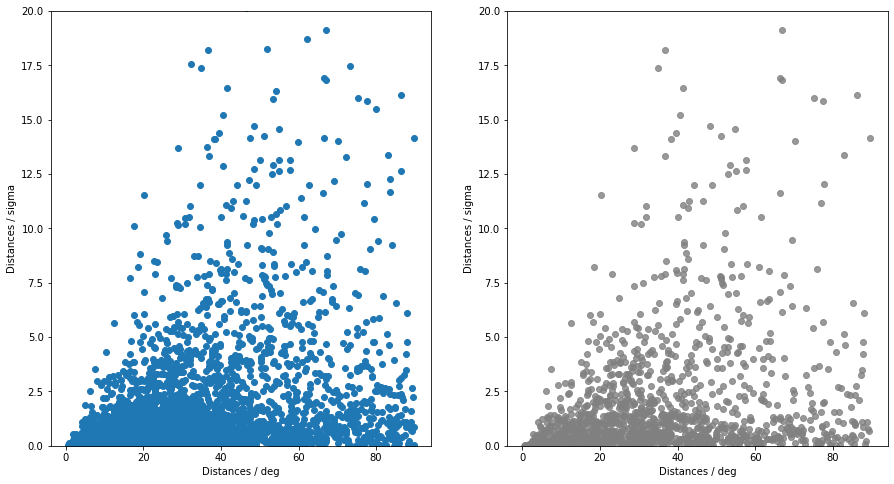

In [26]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,20] ]
# b = [90,50]

x = data['spins.distance'] #/ data['SHG1G2_dSpin']
y = data['spins.distance'] / data['SHG1G2_dSpin']
ax[0].scatter( x, y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select', color='grey', alpha=0.8 )

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')
    a.set_ylim(r[1])

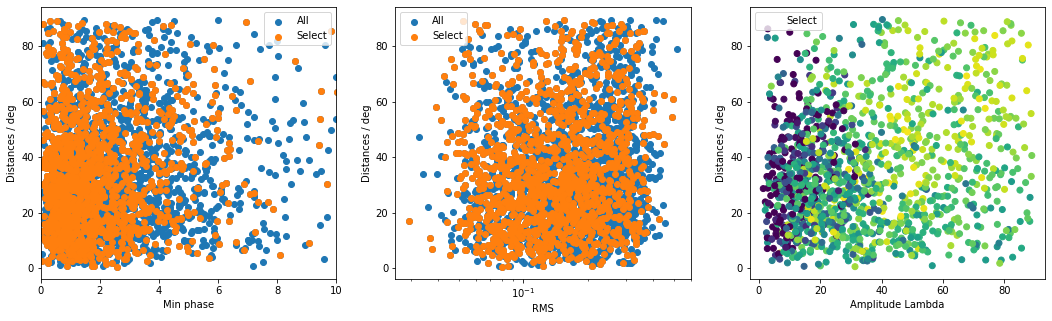

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

x = data['min_phase']
y = data['spins.distance']
ax[0].scatter( x,y, label='All' )
ax[0].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)

x = data['SHG1G2_rms']
y = data['spins.distance']
ax[1].scatter( x,y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

# x = np.degrees(np.arccos(data['SHG1G2_maxCosLambda'] - data['SHG1G2_minCosLambda']))
x = np.degrees(np.arccos(data['SHG1G2_min_cos_lambda']) - np.arccos(data['SHG1G2_max_cos_lambda']))
y = data['spins.distance']
# ax[2].scatter( x, y, label='All' )
ax[2].scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'SHG1G2_R'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('Amplitude Lambda')
# ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_vs_obs.png'), facecolor='white')

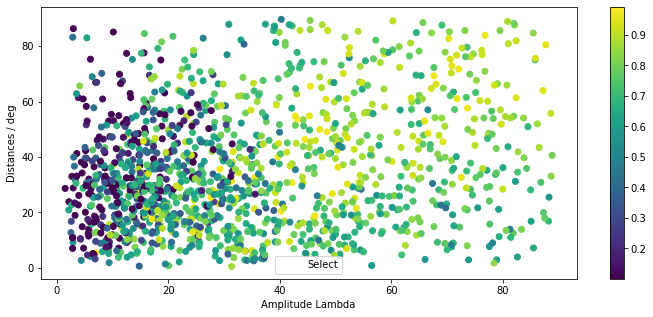

In [28]:
fig, ax = plt.subplots(figsize=(12,5))

x = np.degrees(np.arccos(data['SHG1G2_min_cos_lambda']) - np.arccos(data['SHG1G2_max_cos_lambda']))
y = data['spins.distance']
im = ax.scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'SHG1G2_R'], label='Select' )
ax.legend()
ax.set_xlabel('Amplitude Lambda')
ax.set_ylabel('Distances / deg')

fig.colorbar(im)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

Text(0, 0.5, 'Distances / deg')

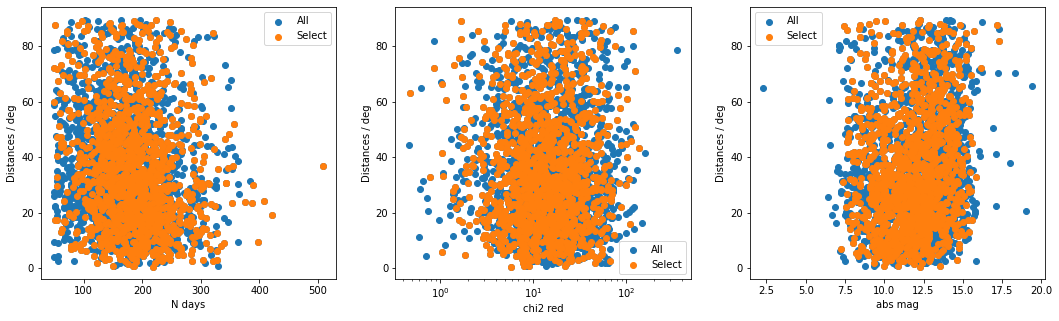

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'SHG1G2_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'SHG1G2_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


(56433, 2828)

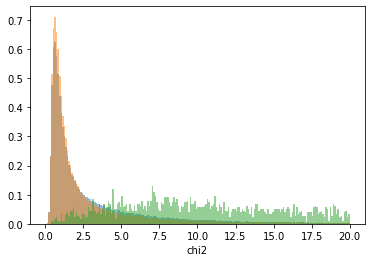

In [30]:
r = [0,20]
b = 200 
plt.hist(data['SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(56433, 2828)

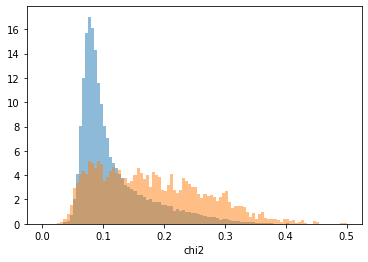

In [31]:
r = [0,0.5]
b = 100 
# plt.hist(data['SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

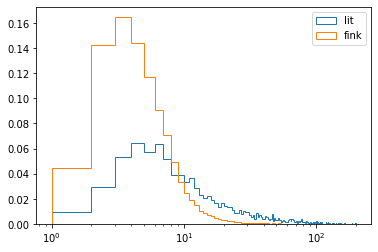

In [32]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [33]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

LCI       295
LC+TPM     87
LC         15
LC-TPM      5
ADAM        5
TE          3
LC+Occ      3
Radar       2
Name: spins.1.technique, dtype: int64

In [34]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

,ssnamenr,HG_dG_g,HG_fit,HG_rms,HG_chi2red,HG_dH_g,HG_dG_r,HG_dH_r,HG_rms_r,HG_rms_g,...,spins.4.DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin
87215,24,0.019890,0.0,0.043779,4.425792,0.020195,0.034698,0.039076,0.042324,0.044573,...,NaN,0,7.035897,-7.112350,-1.168778,3.667,2.576,246.135000,246.135000,2.972686
84025,33,0.021935,0.0,0.055226,5.222732,0.019200,0.024709,0.020889,0.053934,0.057040,...,NaN,0,45.527728,-22.492766,-35.656769,2.000,3.000,157.258000,157.258000,3.521678
99482,38,0.037827,0.0,0.083786,15.205956,0.034969,0.041726,0.038746,0.093978,0.076580,...,NaN,0,6.514856,-3.057101,-5.767179,5.000,5.000,335.139000,335.139000,6.751386
100925,41,0.058974,0.0,0.158316,74.706360,0.079054,0.118922,0.163260,0.130622,0.173880,...,NaN,0,87.329663,-13.478791,86.083719,3.837,3.837,1.482000,1.482000,5.425430
61955,45,0.227867,0.0,0.259946,156.192383,0.196210,0.148732,0.203303,0.272028,0.245827,...,NaN,0,26.607345,-8.678705,25.441661,2.000,2.000,121.039000,121.039000,2.250214
64841,46,0.018800,0.0,0.057734,9.474948,0.024344,0.024934,0.030953,0.061030,0.053498,...,NaN,0,8.114700,-6.400177,4.806181,5.000,5.000,112.808000,112.808000,5.362528
53310,47,0.042015,0.0,0.109368,29.839844,0.041186,0.057475,0.050503,0.105838,0.112085,...,NaN,0,41.292223,201.441192,19.910390,5.000,5.000,335.521000,335.521000,6.760743
23047,49,0.022373,0.0,0.055910,6.232467,0.031231,0.022926,0.027605,0.057955,0.051900,...,NaN,<NA>,NaN,NaN,NaN,15.000,15.000,15.000000,15.000000,NaN
13578,54,0.026602,0.0,0.061022,10.154608,0.030454,0.027173,0.030621,0.061943,0.060005,...,NaN,0,14.119701,-3.698228,13.693222,4.000,3.000,343.635426,343.635426,4.871333
14535,58,0.010953,0.0,0.036848,2.524852,0.012848,0.015240,0.018824,0.038867,0.035029,...,NaN,<NA>,NaN,NaN,NaN,15.000,15.000,15.000000,15.000000,NaN


In [35]:
cond = maskFINK
showcols = ['number','name', #'minphase','maxphase','n_days',
        'SHG1G2_alpha0','SHG1G2_delta0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,showcols].sort_values(by='number').head(20)

,number,name,SHG1G2_alpha0,SHG1G2_delta0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
87215,24,Themis,262.663574,65.681778,246.135000,64.513000,A,NaN,NaN,NaN,7.035897,NaN
84025,33,Polyhymnia,191.986145,-13.976231,157.258000,-49.633000,A,33.456,-43.210,B,45.527728,60.473058
99482,38,Leda,338.225693,13.707179,155.139000,-7.940000,B,346.679,-12.214,A,6.514856,27.242062
100925,41,Daphne,18.118475,-50.198719,181.482000,-35.885000,B,NaN,NaN,NaN,87.329663,NaN
61955,45,Eugenia,130.068130,-41.456661,121.039000,-16.015000,A,NaN,NaN,NaN,26.607345,NaN
64841,46,Hestia,120.116425,24.062819,112.808000,28.869000,A,290.700,-8.943,B,8.114700,17.592867
53310,47,Aglaja,45.869873,-65.846390,155.521000,45.936000,B,317.916,-3.910,A,41.292223,85.595629
23047,49,Pales,85.646393,-63.618279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13578,54,Alexandra,347.729553,-39.097851,163.635426,25.404629,B,NaN,NaN,NaN,14.119701,NaN
14535,58,Concordia,191.804565,-5.062485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data.columns[:80]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_rms', 'HG_chi2red', 'HG_dH_g',
       'HG_dG_r', 'HG_dH_r', 'HG_rms_r', 'HG_rms_g', 'HG_G_g', 'HG_H_r',
       'HG_H_g', 'HG_G_r', 'HG_status', 'HG_flag', 'HG1G2_fit', 'HG1G2_dG2_g',
       'HG1G2_dG1_r', 'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g',
       'HG1G2_G1_r', 'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_dH_g',
       'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r', 'HG1G2_H_g',
       'HG1G2_status', 'HG1G2_flag', 'mean_astrometry', 'max_phase_g',
       'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit', 'SHG1G2_R',
       'SHG1G2_min_cos_lambda', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_G2_g',
       'SHG1G2_G1_r', 'SHG1G2_ddelta0', 'SHG1G2_G1_g', 'std_astrometry',
       'SHG1G2_delta0', 'n_days_r', 'SHG1G2_G2_r', 'n_days_g',
       'SHG1G2_chi2red', 'min_phase', 'SHG1G2_dH_g', 'SHG1G2_dH_r',
       'SHG1G2_rms_r', 'last_jd', 'SHG

# Obliquity

In [45]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


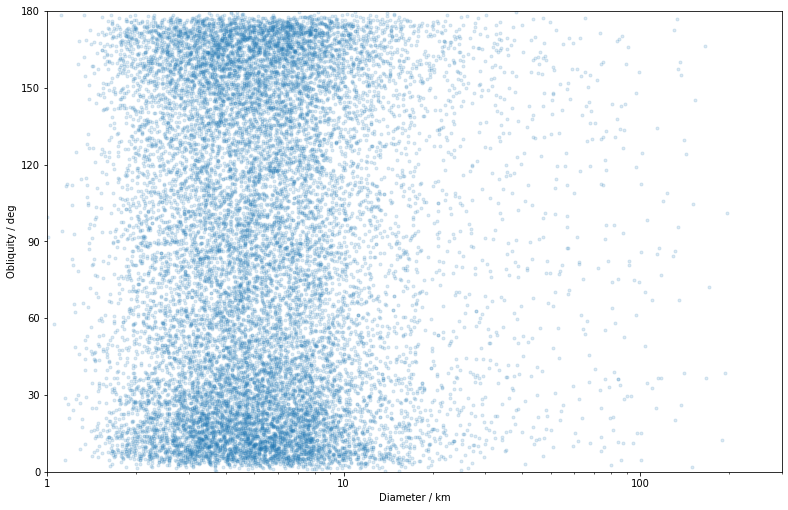

In [47]:
fig, ax = plt.subplots(figsize=(12,8), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            marker='.',
            # color=colors[0], 
            # s=2, 
            alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_ylim(0,180)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')


ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])
ax.set_yticks([0,30,60,90,120,150,180])

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'obliquity_vs_diameter.png'), facecolor='white')

(array([285., 826., 791., 700., 628., 513., 502., 410., 360., 324., 351.,
        284., 297., 269., 268., 288., 288., 315., 306., 303., 286., 272.,
        260., 252., 307., 273., 294., 316., 311., 361., 415., 467., 538.,
        587., 652., 693., 279.]),
 array([  0.        ,   4.86486486,   9.72972973,  14.59459459,
         19.45945946,  24.32432432,  29.18918919,  34.05405405,
         38.91891892,  43.78378378,  48.64864865,  53.51351351,
         58.37837838,  63.24324324,  68.10810811,  72.97297297,
         77.83783784,  82.7027027 ,  87.56756757,  92.43243243,
         97.2972973 , 102.16216216, 107.02702703, 111.89189189,
        116.75675676, 121.62162162, 126.48648649, 131.35135135,
        136.21621622, 141.08108108, 145.94594595, 150.81081081,
        155.67567568, 160.54054054, 165.40540541, 170.27027027,
        175.13513514, 180.        ]),
 <BarContainer object of 37 artists>)

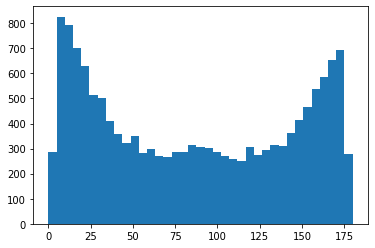

In [48]:
cond = maskFINK & (data['diameter.value']<10)
fig, ax = plt.subplots()

r = [0,180]
b = 37
ax.hist( data.loc[cond,'obliquity'], bins=b, range=r )

In [49]:
np.sqrt(2*np.pi / (5*3600)), np.sqrt(2*np.pi / (5*365.24*86400))

(0.01868330405465976, 0.00019955329064394955)

In [50]:
nu = [1e-8, 1e-4]

ti = 200
emissivity = 0.9
sigma_b = 5.670374419e-8
S_sun = 1360
beaming = 0.9
delta = 3.
pV = 0.15
A = (0.29 + 0.684*0.15) * pV

theta = ti*np.sqrt(nu) * ((beaming * delta**2 )**(3/4)) * ( (sigma_b*emissivity)**(-1/4) ) * ( ((1-A)*S_sun)**(-3/4) )

W = -0.5* theta / (1 + theta + 0.5*theta**2)

Wn = W[0]
Ww = W[1]

print(W)

[-0.01448942 -0.17681723]


In [51]:
data.loc[maskFINK,'family.family_name'].value_counts().head(30)

Vesta         2322
Eos           1961
Hertha        1927
Koronis       1437
Themis         903
Flora          895
Maria          777
Astraea        622
Phocaea        585
Hygiea         569
Eunomia        567
Baptistina     499
Iduna          463
Minerva        445
Hungaria       381
Mnemosyne      310
Adeona         304
Massalia       278
Euphrosyne     253
Levin          240
Dora           204
Tirela         187
Veritas        172
Hansa          170
Eurynome       146
Agnia          145
Erigone        135
Rafita         116
Taiyuan        104
Padua          101
Name: family.family_name, dtype: int64

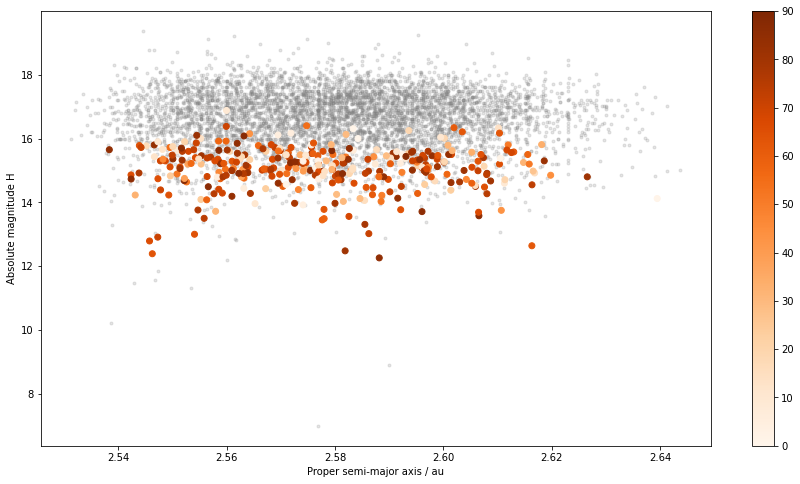

In [52]:
fig, ax = plt.subplots(figsize=(15,8))

f = 'Astraea'

cond = bft['family.family_name']==f
ax.scatter( bft.loc[cond,'proper_elements.proper_semi_major_axis.value'], bft.loc[cond,'absolute_magnitude.value'], color='grey', alpha=0.2, marker='.' )

                    
cond = maskFINK & (data['family.family_name']==f)
im = ax.scatter( data.loc[cond,'proper_elements.proper_semi_major_axis.value'],
            data.loc[cond,'absolute_magnitude.value'],
            c=np.abs(data.loc[cond,'obliquity']-90),
            vmin=0, vmax=90, alpha=1.0, marker='o', cmap='Oranges' )

ax.set_xlabel('Proper semi-major axis / au')
ax.set_ylabel('Absolute magnitude H')
fig.colorbar(im)

# Oblateness

In [53]:
damit = pd.read_csv( os.path.join(data_fink,'data','damit.csv' ) )

In [54]:
np.mean(damit.R), np.mean(damit.R2)

(0.6131972585404972, 0.7431183878107458)

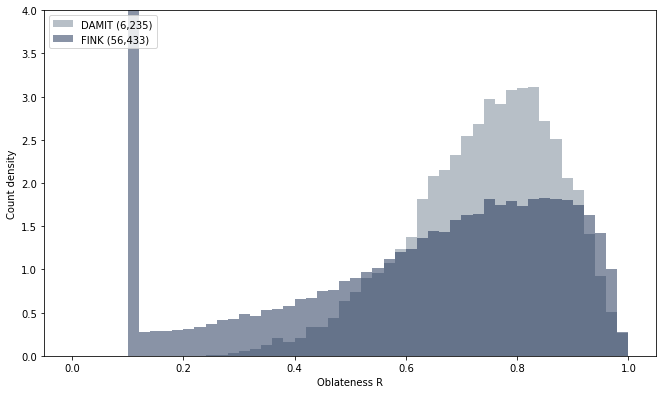

In [55]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(figsize=(10,6), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']


# ax.hist( damit.R, range=r, bins=b, 
#         color='lightgray', 
#         density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist( damit.R2, range=r, bins=b, 
        color='slategray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'SHG1G2_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.SHG1G2_dR<0.9) & maskFINK
ax.hist( data.loc[cond,'SHG1G2_R'], range=r, bins=b, 
         color=colors[0], 
        density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('Oblateness R')
ax.set_ylabel('Count density')
ax.legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


Text(0.5, 0, '(FINK R - DAMIT R) / dR')

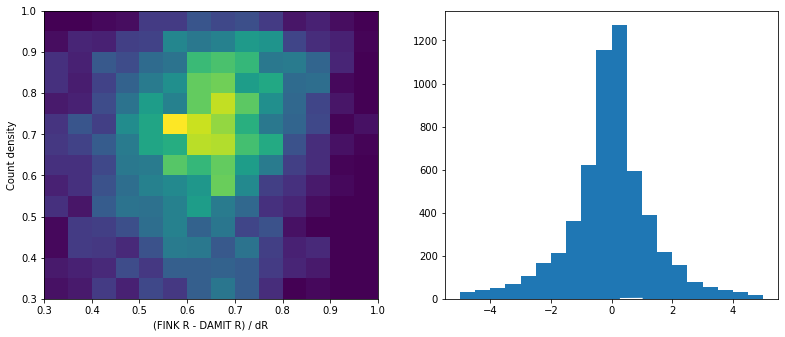

In [56]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(1, 2, figsize=(12,5), 
                       gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']

x = damit.merge(data, left_on='number', right_on='sso_number')

# ax.scatter( x.R, x.SHG1G2_R ) 
ax[0].hist2d( x.R, x.SHG1G2_R, range=[[0.3,1],[0.3,1]], bins=14) 
xx = np.linspace(0.3,1,num=10)
ax[1].plot(xx,xx, color='white')

ax[1].hist( (x.R-x.SHG1G2_R)/x.SHG1G2_dR, range=[-5,5], bins=20 )



# ax.set_ylim(0,4)
ax[0].set_xlabel('FINK R')
ax[0].set_ylabel('Count density')

ax[0].set_xlabel('(FINK R - DAMIT R) / dR')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [57]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.SHG1G2_R>0.18)
data[cond].sort_values(by='SHG1G2_R').head(40)

,ssnamenr,HG_dG_g,HG_fit,HG_rms,HG_chi2red,HG_dH_g,HG_dG_r,HG_dH_r,HG_rms_r,HG_rms_g,...,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin,lon_orbit,lat_orbit,obliquity
23515,108424,0.128528,0.0,0.176291,1.569833,0.137321,0.105506,0.094930,0.173156,0.183710,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,40.679714,78.938023,NaN
110895,112967,0.035861,0.0,0.070143,0.902372,0.039689,0.025630,0.030925,0.070446,0.069723,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,-23.347405,87.493676,NaN
54774,39906,0.064632,0.0,0.096598,0.561079,0.049115,0.046893,0.043084,0.095753,0.097662,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,108.425267,83.336353,156.050035
107736,98705,0.057817,0.0,0.140640,1.976117,0.053626,0.077873,0.061377,0.138402,0.143474,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,264.116833,82.992606,31.351255
71842,11222,0.045084,0.0,0.137595,4.929321,0.050838,0.048950,0.054552,0.137919,0.137178,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,123.068101,80.222386,170.900684
35887,33783,0.068929,0.0,0.188122,7.116027,0.062724,0.073813,0.063789,0.183478,0.193125,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,-35.225550,88.144041,NaN
10907,32995,0.076586,0.0,0.106981,1.080274,0.069214,0.044510,0.047081,0.106086,0.108396,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,32.235568,79.402173,NaN
39606,113791,0.106569,0.0,0.168717,2.588815,0.084821,0.092402,0.067951,0.171062,0.163521,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,-32.933542,83.441974,4.888150
59145,139614,0.068387,0.0,0.105458,0.780311,0.051391,0.050786,0.045352,0.097841,0.115161,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,191.938883,81.722739,NaN
79476,73304,0.120352,0.0,0.109682,0.550600,0.095333,0.070625,0.060542,0.127158,0.064252,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,56.778438,82.749432,30.344876


Text(0, 0.5, 'R')

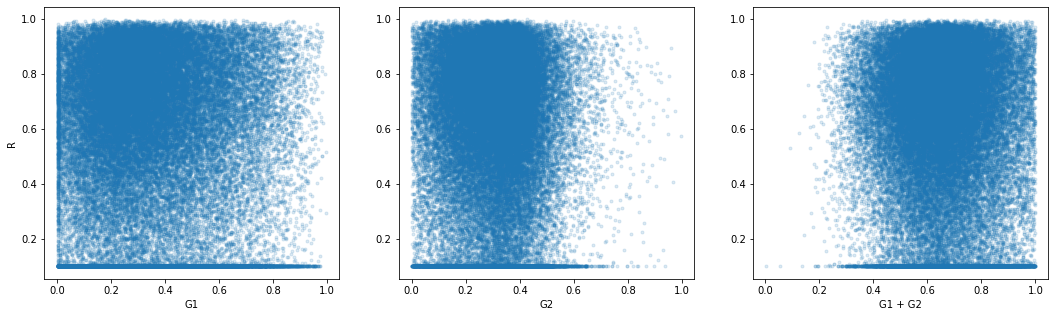

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'SHG1G2_G1_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'SHG1G2_G2_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'SHG1G2_G1_r']+data.loc[cond,'SHG1G2_G2_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')